In [2]:
import requests as req
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from pathlib import Path
from sklearn import linear_model as LM

plt.rcParams['figure.dpi']     = 100
plt.rcParams['figure.figsize'] = 9,7
plt.rcParams['axes.prop_cycle'] = cycler('color', ['cadetblue','orangered','gold', 'navy'])

In [3]:
mortality_data = pd.read_csv(Path('dane\HLTH_CD_ARO.csv'))

mortality_data

,DATAFLOW,LAST UPDATE,freq,unit,sex,age,icd10,resid,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2011,39758.0,NaN
1,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2012,41803.0,NaN
2,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2013,41378.0,NaN
3,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2014,40662.0,NaN
4,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,F,TOTAL,A-R_V-Y,TOT_IN,AT,2015,43159.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4769935,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,T,Y_LT65,Y10-Y34_Y872,TOT_RESID,UK,2014,995.0,NaN
4769936,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,T,Y_LT65,Y10-Y34_Y872,TOT_RESID,UK,2015,1020.0,NaN
4769937,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,T,Y_LT65,Y10-Y34_Y872,TOT_RESID,UK,2016,936.0,NaN
4769938,ESTAT:HLTH_CD_ARO(1.0),30/09/22 23:00:00,A,NR,T,Y_LT65,Y10-Y34_Y872,TOT_RESID,UK,2017,1021.0,NaN


In [4]:
mortality_data.drop(['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'OBS_FLAG'], axis = 1, inplace=True)


In [5]:
mortality_data_PL = mortality_data[(mortality_data['geo']=='PL') & (mortality_data['icd10'] == 'A-R_V-Y') & (mortality_data['age'] == 'TOTAL') & (mortality_data['sex'] == 'T') & (mortality_data['resid'] == 'TOT_IN')]
mortality_data_PL

,sex,age,icd10,resid,geo,TIME_PERIOD,OBS_VALUE
3154152,T,TOTAL,A-R_V-Y,TOT_IN,PL,2011,376150.0
3154153,T,TOTAL,A-R_V-Y,TOT_IN,PL,2012,385456.0
3154154,T,TOTAL,A-R_V-Y,TOT_IN,PL,2013,387988.0
3154155,T,TOTAL,A-R_V-Y,TOT_IN,PL,2014,377182.0
3154156,T,TOTAL,A-R_V-Y,TOT_IN,PL,2015,395578.0
3154157,T,TOTAL,A-R_V-Y,TOT_IN,PL,2016,388677.0
3154158,T,TOTAL,A-R_V-Y,TOT_IN,PL,2017,403559.0
3154159,T,TOTAL,A-R_V-Y,TOT_IN,PL,2018,414941.0
3154160,T,TOTAL,A-R_V-Y,TOT_IN,PL,2019,410564.0
3154161,T,TOTAL,A-R_V-Y,TOT_IN,PL,2020,478008.0


In [6]:
LM_reg = LM.LinearRegression()
LM_reg.fit(mortality_data_PL['TIME_PERIOD'].iloc[:-1].values.reshape(-1, 1), mortality_data_PL['OBS_VALUE'].iloc[:-1].values.reshape(-1, 1))
LM_reg.coef_
LM_reg.score(mortality_data_PL['TIME_PERIOD'].values.reshape(-1, 1), mortality_data_PL['OBS_VALUE'].values.reshape(-1, 1))


0.47261245499548543

In [7]:
preds = pd.DataFrame()
preds['rok'] = [r for r in range(2011,2021)]
preds['y_pred'] = LM_reg.predict(preds['rok'].values.reshape(-1,1))
preds.set_index('rok',inplace = True)
mortality_data_PL.set_index('TIME_PERIOD', inplace = True)



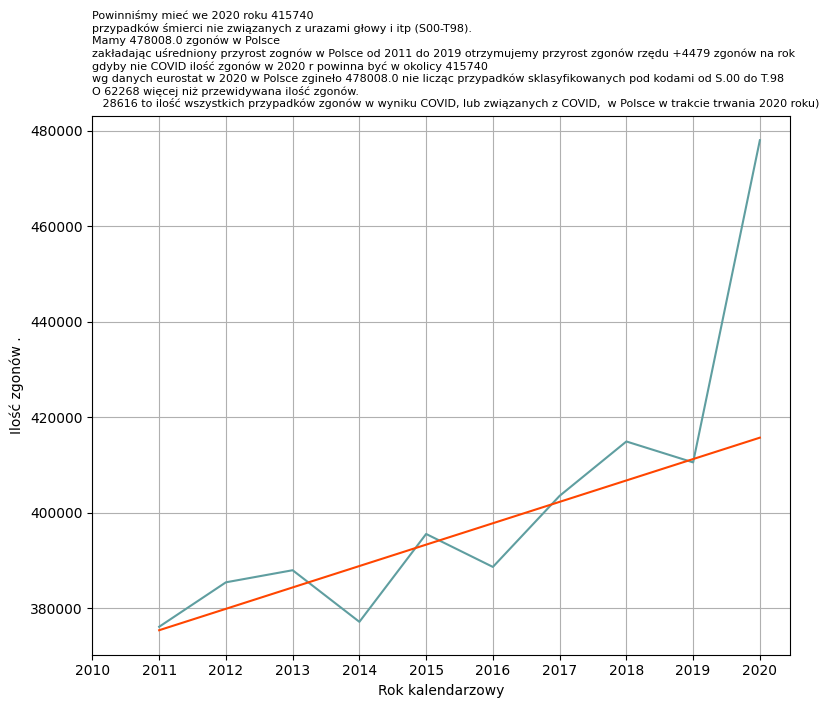

In [8]:
sns.lineplot(data = mortality_data_PL, x = 'TIME_PERIOD', y = mortality_data_PL['OBS_VALUE'])
sns.lineplot(data = preds, x = 'rok', y = 'y_pred')
plt.xticks([x for x in range(2010,2021)])
plt.grid('both')
plt.ylabel('Ilość zgonów .')
plt.xlabel('Rok kalendarzowy')
plt.title(f"""Powinniśmy mieć we 2020 roku {preds.loc[2020,'y_pred']:.0f}
przypadków śmierci nie związanych z urazami głowy i itp (S00-T98).
Mamy {mortality_data_PL.loc[2020,'OBS_VALUE']} zgonów w Polsce
zakładając uśredniony przyrost zognów w Polsce od 2011 do 2019 otrzymujemy przyrost zgonów rzędu {float(LM_reg.coef_):+.0f} zgonów na rok
gdyby nie COVID ilość zgonów w 2020 r powinna być w okolicy {preds.loc[2020,'y_pred']:.0f}
wg danych eurostat w 2020 w Polsce zgineło {mortality_data_PL.loc[2020,'OBS_VALUE']} nie licząc przypadków sklasyfikowanych pod kodami od S.00 do T.98
O {mortality_data_PL.loc[2020, 'OBS_VALUE'] - preds.loc[2020, 'y_pred']:.0f} więcej niż przewidywana ilość zgonów.
   28616 to ilość wszystkich przypadków zgonów w wyniku COVID, lub związanych z COVID,  w Polsce w trakcie trwania 2020 roku)""", loc = 'left', fontsize = 8)
plt.show()

In [9]:
for i, j in mortality_data[(mortality_data['resid'] == 'TOT_IN') & (mortality_data['geo'] == 'PL') & (mortality_data['sex'] == 'T') & (mortality_data['age'] == 'TOTAL')].groupby('icd10'):
    break
print(j)

        sex    age    icd10   resid geo  TIME_PERIOD  OBS_VALUE
3154152   T  TOTAL  A-R_V-Y  TOT_IN  PL         2011   376150.0
3154153   T  TOTAL  A-R_V-Y  TOT_IN  PL         2012   385456.0
3154154   T  TOTAL  A-R_V-Y  TOT_IN  PL         2013   387988.0
3154155   T  TOTAL  A-R_V-Y  TOT_IN  PL         2014   377182.0
3154156   T  TOTAL  A-R_V-Y  TOT_IN  PL         2015   395578.0
3154157   T  TOTAL  A-R_V-Y  TOT_IN  PL         2016   388677.0
3154158   T  TOTAL  A-R_V-Y  TOT_IN  PL         2017   403559.0
3154159   T  TOTAL  A-R_V-Y  TOT_IN  PL         2018   414941.0
3154160   T  TOTAL  A-R_V-Y  TOT_IN  PL         2019   410564.0
3154161   T  TOTAL  A-R_V-Y  TOT_IN  PL         2020   478008.0


In [10]:
estat = req.get('https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/hlth_cd_aro')
estat.json().keys()

dict_keys(['version', 'class', 'label', 'source', 'updated', 'value', 'status', 'id', 'size', 'dimension', 'extension'])

In [11]:
for i, j in estat.json()['dimension']['icd10']['category']['label'].items():
    print(f'{i=}  {j=}')

i='A-R_V-Y'  j='All causes of death (A00-Y89) excluding S00-T98'
i='A_B'  j='Certain infectious and parasitic diseases (A00-B99)'
i='A15-A19_B90'  j='Tuberculosis'
i='B15-B19_B942'  j='Viral hepatitis and sequelae of viral hepatitis'
i='B180-B182'  j='Chronic viral hepatitis B and C'
i='B20-B24'  j='Human immunodeficiency virus [HIV] disease'
i='A_B_OTH'  j='Other infectious and parasitic diseases (remainder of A00-B99)'
i='C00-D48'  j='Neoplasms'
i='C'  j='Malignant neoplasms (C00-C97)'
i='C00-C14'  j='Malignant neoplasm of lip, oral cavity, pharynx'
i='C15'  j='Malignant neoplasm of oesophagus'
i='C16'  j='Malignant neoplasm of stomach'
i='C18-C21'  j='Malignant neoplasm of colon, rectosigmoid junction, rectum, anus and anal canal'
i='C22'  j='Malignant neoplasm of liver and intrahepatic bile ducts'
i='C25'  j='Malignant neoplasm of pancreas'
i='C32'  j='Malignant neoplasm of larynx'
i='C33_C34'  j='Malignant neoplasm of trachea, bronchus and lung'
i='C43'  j='Malignant melanoma of s

In [12]:
kody_icd10 = estat.json()['dimension']['icd10']['category']['label']

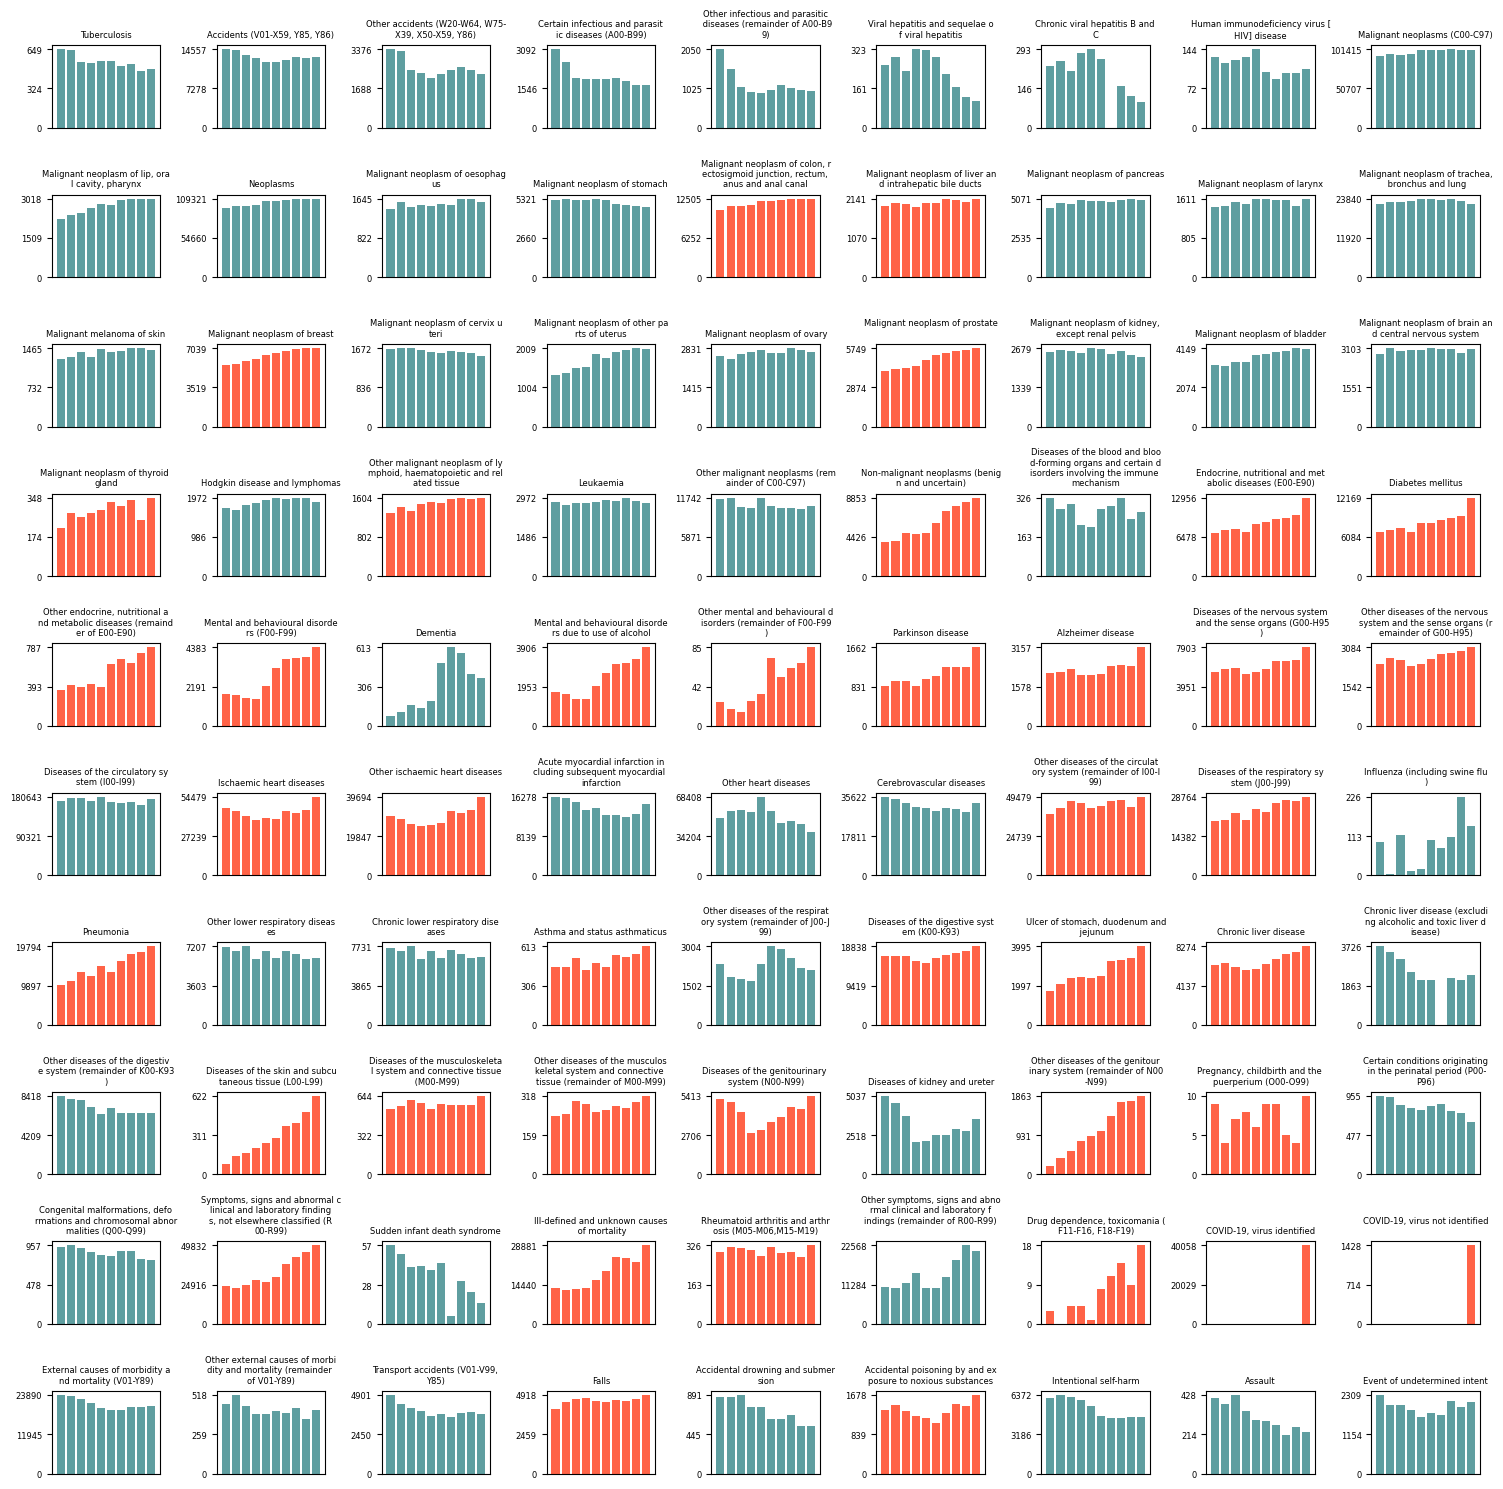

In [13]:
mortality_data[(mortality_data['geo'] == 'PL') & (mortality_data['sex'] == 'T')].groupby('icd10')

fig, axs = plt.subplots(10,9, figsize = (15,15), tight_layout = False, sharex = True)
for i, (icd10, grupa) in enumerate(mortality_data[(mortality_data['resid'] == 'TOT_IN') & (mortality_data['geo'] == 'PL') & (mortality_data['sex'] == 'T') & (mortality_data['age'] == 'TOTAL') & (mortality_data['icd10'] != 'A-R_V-Y')].groupby('icd10')):
    #print(f"  {i=}   { icd10=  }  {pl=}")
    kulior = 'tomato' if grupa.iloc[-1,-1] == grupa['OBS_VALUE'].max() else 'cadetblue'
    #print(f'axes[{i//9, i % 9}]  kolor {kulior}   {grupa.iloc[-1,-1]}')
    axs[i//9, i % 9].bar(x=grupa['TIME_PERIOD'], width = 0.8, height = grupa.loc[:,'OBS_VALUE'], color = kulior)
    axs[i//9, i % 9].set_title('\n'.join([kody_icd10[icd10][x*30:(x+1)*30] for x in range(0,len(kody_icd10[icd10])//30+1)]), fontsize = 6)
    axs[i//9, i % 9].set_xticks([])
    axs[i//9, i % 9].set_yticks([int(x/2*grupa['OBS_VALUE'].max()) for x in range(0,3)], labels = [str(int(x/2*grupa['OBS_VALUE'].max())) for x in range(0,3)], size = 6)